In [175]:
import json
with open("config.json") as f:
    config = json.load(f)
cov_path = config["cov_path"]
map_2_emu_path = config["map_2_emu_path"]
map_3_emu_path = config["map_3_emu_path"]
nautilus_path = config["nautilus_path"]
main_path = config["main_path"]

In [176]:
import os
print(os.getcwd())
import sys
sys.path.append(main_path)
print(os.getcwd())

# Load all modules
import emulator_3pt

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.linalg import inv
import gdown
from nautilus import Prior
from nautilus import Sampler
import os
import jax.numpy as jnp

/mnt/c/Users/Akshay/Documents/Project_work/MCMC_project/sampler_comparison-main/sampler_comparison-main
/mnt/c/Users/Akshay/Documents/Project_work/MCMC_project/sampler_comparison-main/sampler_comparison-main


In [177]:
# # Download the covariance matrix and parameters
# gdown.download(id='1H1H_tH43rOIeOUW6cY5cx8LjpscgaMeD',output='../outputs/cov_T17.npy')


# Load the precomputed covariance matrix (shape: 40 x 40)
cov = np.load(cov_path)

# Dimensions
ns = 570 # number of simulations
nd = 40
ndim = 8

# Hartlap correction-inspired term
B = (ns - nd - 2) / ((ns - nd - 1) * (ns - nd - 4))
m = ndim + 2 + (ns - 1 + B * (nd - ndim)) / (1 + B * (nd - ndim))

# Inverse covariance
inv_cov = inv(cov)


In [178]:
# --- Step 2: Define the prior over model parameters ---
prior = Prior()
prior.add_parameter('Omega_m', dist=(0.23008603805291986, 0.39969071100893877))
prior.add_parameter('sigma8', dist=(0.7300666536240268, 0.8999825383034264))
prior.add_parameter('Omega_b', dist=(0.04000982924130305, 0.059994733919925755))
prior.add_parameter('M1_z0_cen', dist=(9.000497821926116, 12.997892823056496))
prior.add_parameter('M_c', dist=(10.009180624129629, 15.99716430647626))
prior.add_parameter('beta', dist=(-0.9967784660541272, 0.6992383181501483))
prior.add_parameter('eta', dist=(-0.6977833279473113, 0.1991947243758576))
prior.add_parameter('theta_inn', dist=(-1.9998000600318366, -0.00020501523840121827))

In [179]:
# #Download the emulator
# gdown.download(id='1EIwS-GgreuoNFBVOg9b94GhmoFekiLG1',output='../outputs/Map2_emu_converted.npz')
# gdown.download(id='1sXXpqwTzz-JZh6VSmWaSGDmVQGLsNLc1',output='../outputs/Map3_emu_nell64_nphi512_converted.npz')

# --- Step 3: Restore pretrained emulator for the Map23 statistic ---
Map2_emu = emulator_3pt.cosmoemu_jax(filepath=map_2_emu_path)
Map3_emu = emulator_3pt.cosmoemu_jax(filepath=map_3_emu_path)


priors_params = { 
                'M1_z0_cen': [9.000497821926116, 12.997892823056496], 
                'M_c': [10.009180624129629, 15.99716430647626], 
                'beta': [-0.9967784660541272, 0.6992383181501483], 
                'eta': [-0.6977833279473113, 0.1991947243758576], 
                'theta_inn': [-1.9998000600318366, -0.00020501523840121827],
                'Omega_m': [0.23008603805291986, 0.39969071100893877],
                'Omega_b': [0.04000982924130305, 0.059994733919925755],
                'sigma8': [0.7300666536240268, 0.8999825383034264],
            }

para_names_varying = priors_params.keys()

param_dict_emu_true = {name: jnp.asarray([priors_params[name][1]/2+priors_params[name][0]/2], dtype=jnp.float32) for name in para_names_varying}
print(param_dict_emu_true)

Map2_model = Map2_emu.ten_to_rescaled_predict(param_dict_emu_true)
Map3_model = Map3_emu.ten_to_rescaled_predict(param_dict_emu_true)
data = np.concatenate((Map2_model, Map3_model))
data


/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map2_emu_converted.npz
KeysView(NpzFile '/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map2_emu_converted.npz' with keys: n_parameters, parameters, feature_dimensions, scaling_division, scaling_subtraction...)
/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map3_emu_nell64_nphi512_converted.npz
KeysView(NpzFile '/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map3_emu_nell64_nphi512_converted.npz' with keys: n_parameters, parameters, feature_dimensions, scaling_division, scaling_subtraction...)
{'M1_z0_cen': Array([10.999195], dtype=float32), 'M_c': Array([13.003173], dtype=float32), 'beta': Array([-0.14877008], dtype=float32), 'eta': Array([-0.2492943], dtype=float32), 'theta_inn': Array([-1.0000025], dtype=float32), 'Omega_m': Array([0.3148884], dtype=float32), 'Omega_b': Array([0.05000228], d

array([1.0373104e-05, 6.9024700e-06, 4.0987356e-06, 2.4265528e-06,
       1.4889273e-06, 6.3597575e-08, 4.0477303e-08, 1.9791937e-08,
       8.7874321e-09, 3.8652641e-09, 2.6015130e-08, 1.1987660e-08,
       5.1634754e-09, 2.3082467e-09, 4.2711110e-09, 1.5020730e-09,
       6.2491534e-10, 3.7905229e-10, 1.2383462e-10, 2.7781343e-11,
       2.5694384e-08, 1.4967046e-08, 7.1493278e-09, 3.2396923e-09,
       8.6023864e-09, 3.7755035e-09, 1.6511909e-09, 1.2109629e-09,
       4.3223436e-10, 1.0605445e-10, 7.8317344e-09, 4.3985700e-09,
       2.1196558e-09, 2.3755067e-09, 1.0649880e-09, 3.3906128e-10,
       2.0960176e-09, 1.2129163e-09, 6.5972744e-10, 5.8111388e-10],
      dtype=float32)

In [180]:
# --- Step 4: Define the log-likelihood function using emulator predictions ---
def calc_likelihood(param_dict):
    
    # Get the parameters   
    param_dict_emu = {name: jnp.asarray([param_dict[name]], dtype=jnp.float32) for name in para_names_varying}

    
    # Get model prediction

    Map2_model = Map2_emu.ten_to_rescaled_predict(param_dict_emu)
    Map3_model = Map3_emu.ten_to_rescaled_predict(param_dict_emu)
    model = jnp.concatenate((Map2_model, Map3_model))
    
    delta = data-model
    chi2 = np.matmul(delta,np.matmul(inv_cov,delta))
    likelihood = - 0.5 * m * np.log(1 + chi2 / (ns - 1.))
    
    return likelihood

sampler = Sampler(prior, calc_likelihood, n_live=2000)
sampler.run(verbose=True)
points, log_w, log_l = sampler.posterior()
log_z = sampler.log_z

from pathlib import Path

path = Path(nautilus_path)
new_save_path = path.with_suffix("")
print(new_save_path) 

np.savez(str(new_save_path),points=points,log_w=log_w,log_l=log_l,log_z=log_z,para_names_varying=prior.keys)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 22     | 1        | 4        | 53200    | N/A    | 18738 | -11.68   
/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples_Map23_nautilus


Removed no burn in


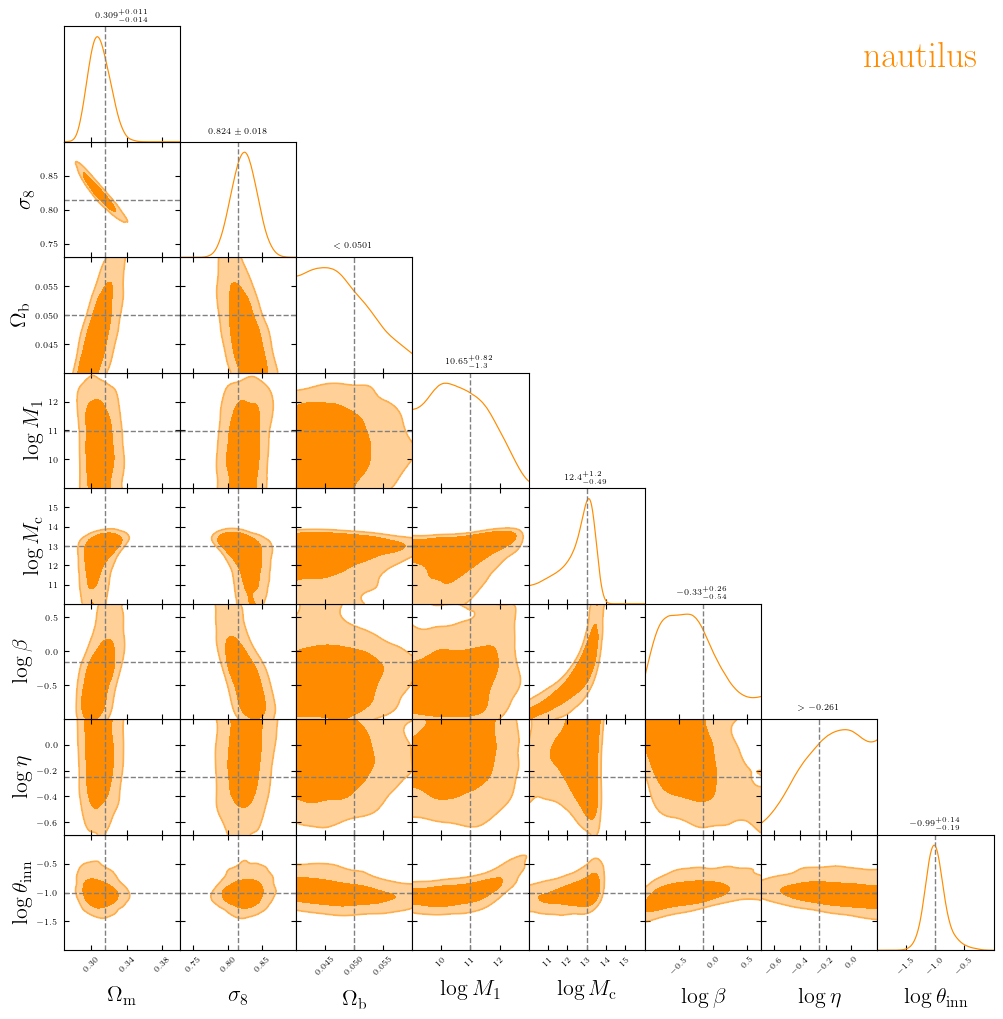

In [181]:
# --- Step 5: Set up GetDist for visualization of parameter inference results ---
from getdist import plots, MCSamples, parampriors
import getdist
import numpy as np

from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)  # Adjust width & height
plt.rcParams["figure.dpi"] = 100  # Lower DPI for smaller display



para_names_latex = [r'$\Omega_\mathrm{m}$', r'$\sigma_8$', r'$\Omega_\mathrm{b}$', r'$\log M_1$', r'$\log M_\mathrm{c}$', r'$\log \beta$', r'$\log \eta$', r'$\log \theta_\mathrm{inn}$']


priors_params = { 
                'M1_z0_cen': [9.000497821926116, 12.997892823056496], 
                'M_c': [10.009180624129629, 15.99716430647626], 
                'beta': [-0.9967784660541272, 0.6992383181501483], 
                'eta': [-0.6977833279473113, 0.1991947243758576], 
                'theta_inn': [-1.9998000600318366, -0.00020501523840121827],
                'Omega_m': [0.23008603805291986, 0.39969071100893877],
                'Omega_b': [0.04000982924130305, 0.059994733919925755],
                'sigma8': [0.7300666536240268, 0.8999825383034264],
            }

para_names = list(priors_params.keys())



if(os.path.exists('../outputs/mcmc_samples_Map23_HMC_warmup.npy')):
    mcmc_samples = np.load('../outputs/mcmc_samples_Map23_HMC.npy',allow_pickle=True).item()
    names = ['Omega_m', 'sigma8', 'Omega_b', 'M1_z0_cen', 'M_c', 'beta', 'eta', 'theta_inn']
    samples_HMC = np.array([mcmc_samples[names[0]],mcmc_samples[names[1]],mcmc_samples[names[2]],mcmc_samples[names[3]],mcmc_samples[names[4]],mcmc_samples[names[5]],mcmc_samples[names[6]],mcmc_samples[names[7]]]).T[50_000:]
    samples_HMC = MCSamples(samples=samples_HMC,names = names, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

samples_nautilus = np.load(nautilus_path)
samples, names = samples_nautilus['points'], samples_nautilus['para_names_varying']
samples_nautilus = MCSamples(samples=samples,weights= np.exp(samples_nautilus['log_w']),names = names, labels = para_names_latex, ranges = priors_params, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


para_truth = {name: priors_params[name][1]/2+priors_params[name][0]/2 for name in para_names_varying}


colors = ['black','C2','C0']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['darkorange', 'blue', 'green','darkorange']

# retro = ['black','#e770a2','#4165c0','#5ac3be', '#696969', '#f79a1e', '#ba7dcd']


g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
# g.settings.axis_marker_ls = '-' 
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'grey'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 30
g.settings.axes_fontsize = 10
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()

contour_colors = ['darkorange', 'black'] 

if(os.path.exists('../outputs/mcmc_samples_Map23_HMC_warmup.npy')):
    g.triangle_plot(
        roots=[samples_nautilus, samples_HMC],
        filled=[True, False],
        contour_colors=contour_colors,
        legend_loc='upper right',
        legend_labels = ['nautilus','HMC'],
        title_limit=1,
        markers=para_truth,
    )
else:
    g.triangle_plot(
        roots=[samples_nautilus],
        filled=[True],
        contour_colors=contour_colors,
        legend_loc='upper right',
        legend_labels = ['nautilus'],
        title_limit=1,
        markers=para_truth,
    )


